# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Introduction</p>

In [1]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

# PATHS
IMG_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/'

2025-05-24 17:57:14.458702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748109434.659569      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748109434.714194      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
metadata = pd.read_csv('/kaggle/input/chest-x-ray-lungs-segmentation/MetaData.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Helper Functions</p>

In [3]:
def get_colored_mask(image, mask_image, color=[255, 20, 255]):
    """
    Overlays a colored segmentation mask on top of an input image.

    Parameters:
    -----------
    image : numpy.ndarray
        The original input image (BGR format).
    
    mask_image : numpy.ndarray
        The segmentation mask image (usually binary or color-coded).
    
    color : list or tuple of 3 ints, optional
        The BGR color used to color the mask overlay. Default is magenta [255, 20, 255].

    Returns:
    --------
    numpy.ndarray
        The image with the segmentation mask overlay applied using the specified color.
    """

    # Convert the mask image to grayscale to isolate the regions of interest
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    # Apply the grayscale mask to extract relevant regions from the mask image
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    # Identify the coordinates where the mask is not black (non-zero pixels)
    mask_coord = np.where(mask != [0, 0, 0])

    # Apply the specified color to those mask coordinates
    mask[mask_coord[0], mask_coord[1], :] = color

    # Blend the original image and the colored mask using transparency weights
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)

    return ret


In [4]:
def plot_training_history(history, metrics):
    """
    Plots training and validation metrics from a Keras History object.

    Parameters:
    -----------
    history : keras.callbacks.History
        History object returned by model.fit(), containing training metrics.

    metrics : list of str
        List of metrics to plot (e.g., ['loss', 'accuracy', 'auc', 'recall']).

    Returns:
    --------
    None
    """
    n = len(metrics)
    rows = (n + 1) // 2  # Ensure enough rows for odd number of plots

    plt.figure(figsize=(10, rows * 4))

    for i, metric in enumerate(metrics):
        plt.subplot(rows, 2, i + 1)

        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is None or val_metric is None:
            print(f"Warning: '{metric}' or 'val_{metric}' not found in history. Skipping.")
            continue

        plt.plot(train_metric, label=f'Train {metric.capitalize()}')
        plt.plot(val_metric, label=f'Val {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_seg_preds(model, val_data, index=1, overlay_color=[0, 255, 30]):
    """
    Visualize image, ground truth mask, and predicted mask from a segmentation model.

    Parameters
    ----------
    model : keras.Model
        Trained segmentation model used for prediction.

    val_data : keras.utils.Sequence
        Validation data generator that yields images and masks.

    index : int, optional
        Index of the batch to visualize from the data generator. Default is 1.

    overlay_color : list, optional
        BGR color for the predicted mask overlay. Default is ([0, 255, 30]).

    Returns
    -------
    None
    """
    # Fetch the batch from the validation generator
    imgs, masks = val_data.__getitem__(index)

    for img, true_mask in zip(imgs, masks):
        # Prepare image for prediction (add batch dimension)
        img_input = np.expand_dims(img, axis=0)

        # Predict mask and postprocess
        pred_mask = model.predict(img_input, verbose=0)
        pred_mask = (np.squeeze(pred_mask) * 255).astype(np.uint8)

        # Prepare original image and ground truth mask
        img_disp = (np.squeeze(img) * 255).astype(np.uint8)
        true_mask_disp = (true_mask * 255).astype(np.uint8)

        # Convert to RGB for visualization
        img_rgb = cv2.cvtColor(img_disp, cv2.COLOR_GRAY2RGB)
        true_mask_rgb = cv2.cvtColor(true_mask_disp, cv2.COLOR_GRAY2RGB)
        pred_mask_rgb = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2RGB)

        # Setup plot
        titles = ['Image', 'Mask (Actual)', 'Mask (Prediction)']
        images = [
            img_rgb,
            get_colored_mask(img_rgb, true_mask_rgb),
            get_colored_mask(img_rgb, pred_mask_rgb, color=overlay_color)
        ]

        plt.figure(figsize=(12, 4))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Custom Data Generators</p>

### **Custom Data Generator for Segmentation**

In [6]:
class DataGeneratorSegmentation(keras.utils.PyDataset):
    """
    Custom data generator for segmentation tasks using Keras's PyDataset class.
    Handles loading, preprocessing, and optional shuffling of image-mask pairs.

    Attributes:
    -----------
    img_filenames : list
        List of image filenames.
    mask_filenames : list
        List of mask filenames corresponding to the images.
    batch_size : int
        Number of samples per batch.
    size : tuple
        Target (height, width) for resizing images and masks.
    seed : int
        Random seed for reproducibility.
    shuffle : bool
        Whether to shuffle data at the end of each epoch.
    indexes : ndarray
        Array of shuffled/ordered indices for accessing the dataset.
    """

    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle
        
        # Ensure images and masks count match
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"
        
        self.indexes = np.arange(len(self.img_filenames))
        
        # Shuffle indices if enabled
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates one batch of data.
        
        Parameters:
        -----------
        index : int
            Index of the batch.
        
        Returns:
        --------
        images : ndarray
            Batch of input images.
        masks : ndarray
            Batch of corresponding binary masks.
        """
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        masks = []
        
        for idx in batch_indices:
            # Load and preprocess image
            img = imread(os.path.join(IMG_PATH, self.img_filenames[idx]), 0)
            img = resize(img, self.size)
            img = img / 255.0

            # Load and preprocess mask
            mask = imread(os.path.join(MSK_PATH, self.mask_filenames[idx]), 0)
            mask = resize(mask, self.size)
            mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0
            mask[mask > 0.5] = 1  # Binarize
            
            images.append(img)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset indices after each epoch if enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

### **Custom Data Generator for Classification**

In [7]:
class DataGeneratorClassification(keras.utils.PyDataset):
    """
    Custom Keras-compatible data generator for image classification tasks.
    
    This generator yields batches of grayscale images and their corresponding labels. 
    Images are resized, normalized, and optionally shuffled after each epoch.
    """

    def __init__(self, img_files, labels, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Initializes the data generator.

        Parameters:
        -----------
        img_files : list
            List of image filenames.
        
        labels : list
            List of labels corresponding to the image files.
        
        batch_size : int, optional (default=32)
            Number of samples per batch.
        
        size : tuple, optional (default=(512, 512))
            Target size to which images will be resized.
        
        seed : int, optional (default=1)
            Random seed for reproducibility.
        
        shuffle : bool, optional (default=True)
            Whether to shuffle the dataset after each epoch.
        """
        super().__init__(**kwargs)

        self.img_filenames = img_files
        self.labels = labels
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        # Ensure the number of images matches the number of labels
        assert len(self.img_filenames) == len(self.labels), \
            "The number of images and labels must be the same"

        self.indexes = np.arange(len(self.img_filenames))

        # Shuffle at initialization if enabled
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.

        Returns:
        --------
        int
            Total number of batches in one epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a single batch of data.

        Parameters:
        -----------
        index : int
            Index of the batch.

        Returns:
        --------
        tuple of np.ndarray
            A tuple containing a batch of images and their corresponding labels.
        """
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        labels = []

        for i, idx in enumerate(batch_indices):
            # Load grayscale image and normalize
            img = imread(IMG_PATH + self.img_filenames[idx], 0)
            img = resize(img, self.size)
            img = img / 255.0

            # Retrieve label
            label = self.labels[idx]

            images.append(img)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        """
        Shuffles the dataset at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

### **Spliting Data into Training and Validation Set**

In [8]:
# Prepare image, mask and labels
img_files = sorted(os.listdir(IMG_PATH))
msk_files = sorted(os.listdir(MSK_PATH))
labels = metadata.sort_values(by='id').ptb.tolist()

# Split data into training and validation sets (stratified by labels for balanced class distribution)
train_img_files, val_img_files, train_msk_files, val_msk_files, train_labels, val_labels = train_test_split(
    img_files, 
    msk_files, 
    labels, 
    test_size=0.3, 
    stratify=labels, 
    random_state=1
)

### **Creating Data Generator for Segmentation**

In [9]:
# Create training data generator
train_seg_data = DataGeneratorSegmentation(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

# Create validation data generator
val_seg_data = DataGeneratorSegmentation(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

### **Creating Data Generator for Classification**

In [10]:
# Instantiate training data generator
train_clf_data = DataGeneratorClassification(
    img_files=train_img_files,
    labels=train_labels,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

# Instantiate validation data generator
val_clf_data = DataGeneratorClassification(
    img_files=val_img_files,
    labels=val_labels,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Model Achitecture</p>

### **Convolution Block for Attention U-Net**

In [11]:
def conv_block(x, filters):
    """
    Convolutional block consisting of two Conv2D layers each followed by
    BatchNormalization and ReLU activation.

    Parameters:
    -----------
    x : Tensor
        Input tensor to the convolutional block.
    filters : int
        Number of filters for the convolutional layers.

    Returns:
    --------
    Tensor
        Output tensor after applying convolution, normalization, and activation.
    """
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    return x

### **Attention Gate Mechanism for Attention U-Net**

In [12]:
def attention_gate(x, g, inter_channels):
    """
    Attention Gate mechanism for filtering encoder features before merging
    with decoder features in an Attention U-Net.

    Parameters:
    -----------
    x : Tensor
        Encoder feature map (skip connection).
    g : Tensor
        Decoder feature map (gating signal).
    inter_channels : int
        Number of intermediate filters used in the attention computation.

    Returns:
    --------
    Tensor
        Refined encoder features after applying attention weights.
    """
    # Linear transformations for encoder (x) and decoder (g) features
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, kernel_size=1, padding='same')(g)
    
    # Add and activate
    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)
    
    # Attention coefficients
    psi = layers.Conv2D(1, kernel_size=1, padding='same')(act)
    sigmoid = layers.Activation('sigmoid')(psi)
    
    # Element-wise multiplication with original encoder features
    return layers.Multiply()([x, sigmoid])

### **Segmentation Model Architecture (Attention U-Net)**

In [13]:
def attention_unet(input_shape=(512, 512, 1), num_classes=1):
    """
    Builds an Attention U-Net model architecture for image segmentation.

    This model incorporates attention gates to enhance skip connections
    by focusing on relevant features and suppressing noise.

    Parameters:
    -----------
    input_shape : tuple, optional (default=(512, 512, 1))
        Shape of the input image including channels (e.g., grayscale images).
    
    num_classes : int, optional (default=1)
        Number of output classes. For binary segmentation, this is 1.

    Returns:
    --------
    model : keras.Model
        A compiled Keras model implementing the Attention U-Net architecture.
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # ------------------- Encoder Path ------------------- #
    # Downsample 1
    conv1 = conv_block(inputs, filters=64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Downsample 2
    conv2 = conv_block(pool1, filters=128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Downsample 3
    conv3 = conv_block(pool2, filters=256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, filters=512)

    # ------------------- Decoder Path with Attention ------------------- #
    # Upsample 1
    up5 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv4)
    att5 = attention_gate(conv3, up5, inter_channels=128)
    merge5 = layers.Concatenate()([up5, att5])
    conv5 = conv_block(merge5, filters=256)

    # Upsample 2
    up6 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv5)
    att6 = attention_gate(conv2, up6, inter_channels=64)
    merge6 = layers.Concatenate()([up6, att6])
    conv6 = conv_block(merge6, filters=128)

    # Upsample 3
    up7 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv6)
    att7 = attention_gate(conv1, up7, inter_channels=32)
    merge7 = layers.Concatenate()([up7, att7])
    conv7 = conv_block(merge7, filters=64)

    # ------------------- Output Layer ------------------- #
    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='sigmoid')(conv7)

    # Model definition
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


### **Classification Model Architecture**

In [14]:
def combined_unet_classifier(seg_model, input_shape=(512, 512, 1)):
    """
    Combines a pre-trained segmentation model (e.g., Attention U-Net) with a classification head.

    This architecture uses the segmentation mask to focus the classifier on the region of interest,
    by multiplying the input image with the predicted mask and then concatenating both as input to the classifier.

    Parameters:
    -----------
    seg_model : keras.Model
        A pre-trained segmentation model. Its weights are frozen before integration.

    input_shape : tuple, optional (default=(512, 512, 1))
        Shape of the input image.

    Returns:
    --------
    keras.Model
        A combined model that performs both segmentation (internally) and classification (externally).
    """

    # Freeze segmentation model weights
    seg_model.trainable = False
    for layer in seg_model.layers:
        layer.trainable = False

    # Input layer
    inputs = keras.Input(shape=input_shape)

    # --- Segmentation Path ---
    unet_output = seg_model(inputs)  # Predicts binary mask of the lung region

    # --- Masking & Feature Fusion ---
    masked = layers.Multiply()([inputs, unet_output])  # Focus image using segmentation
    combined = layers.Concatenate()([inputs, masked])  # Stack original + masked image, shape: (512, 512, 2)

    # --- Classification Path ---
    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Global feature representation
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Output layer for binary classification (e.g., TB vs. Normal)
    x = layers.Dense(1, activation='sigmoid', name='tb_prediction')(x)

    # Build and return model
    model = keras.Model(inputs=inputs, outputs=[x])
    return model


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Custom Metric Functions</p>

In [15]:
@keras.utils.register_keras_serializable()
def jaccard_index(y_true, y_pred, smooth=100):
    """
    Computes the Jaccard Index, also known as Intersection over Union (IoU), 
    which is a common evaluation metric for image segmentation tasks.

    The metric measures the overlap between the predicted and ground truth masks.

    Parameters:
    -----------
    y_true : tensor
        Ground truth binary mask (0s and 1s).
    
    y_pred : tensor
        Predicted binary or probability mask (values between 0 and 1).
    
    smooth : float, optional (default=100)
        Smoothing factor to prevent division by zero.

    Returns:
    --------
    jaccard : tensor
        The computed Jaccard Index value as a scalar tensor.
    """
    # Flatten and cast masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    # Return IoU with smoothing
    return (intersection + smooth) / (union + smooth)

In [16]:
@keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Computes the Dice Coefficient, a metric commonly used for 
    evaluating the performance of image segmentation models.

    It measures the similarity between the predicted and ground truth masks.

    Parameters:
    -----------
    y_true : tensor
        Ground truth binary mask.
    
    y_pred : tensor
        Predicted binary or probability mask.
    
    smooth : float, optional (default=1)
        Smoothing constant to prevent division by zero.

    Returns:
    --------
    dice : tensor
        The Dice coefficient as a scalar tensor.
    """
    # Flatten and cast masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])

    # Compute intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Return Dice coefficient
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Model Training</p>

In [17]:
model = attention_unet()
model.summary()

I0000 00:00:1748109450.269011      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,794,148 (29.73 MB)

 Trainable params: 7,788,516 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [18]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [19]:
checkpoint_dice = ModelCheckpoint(
    'best_seg_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

seg_history = model.fit(
    train_seg_data,
    validation_data=val_seg_data,
    epochs=84,
    callbacks=[checkpoint_dice]
)

Epoch 1/84


I0000 00:00:1748109476.868645      60 service.cc:148] XLA service 0x79b5700025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748109476.869339      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748109479.115043      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748109530.874204      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.8316 - dice_coefficient: 0.5767 - jaccard_index: 0.4202 - loss: 0.3889
Epoch 1: val_dice_coefficient improved from -inf to 0.31901, saving model to best_dice_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8328 - dice_coefficient: 0.5786 - jaccard_index: 0.4222 - loss: 0.3869 - val_accuracy: 0.7373 - val_dice_coefficient: 0.3190 - val_jaccard_index: 0.1899 - val_loss: 0.6168
Epoch 2/84
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9632 - dice_coefficient: 0.8376 - jaccard_index: 0.7211 - loss: 0.1277
Epoch 2: val_dice_coefficient did not improve from 0.31901
61/61 ━━━━━━━━━━━━━━━━━━━━ 60s 953ms/step - accuracy: 0.9632 - dice_coefficient: 0.8378 - jaccard_index: 0.7214 - loss: 0.1275 - val_accuracy: 0.7368 - val_dice_coefficient: 0.2657 - val_jaccard_index: 0.1533 - val_loss: 0.5707
Epoch 3/84
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9722 - dice_coefficient: 0.8707 - jaccard_index: 0.7713 - l

In [20]:
# Load custom metrics
custom_objects = {
    'dice_coefficient': dice_coefficient,
    'jaccard_index': jaccard_index
}

# Load the best model (make sure the path matches your checkpoint)
seg_model = keras.models.load_model('best_seg_model.keras', custom_objects=custom_objects)
clf_model = combined_unet_classifier(seg_model)
clf_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 512, 512, 1)    │      7,794,148 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 512, 512, 1)    │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 512, 512, 2)    │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ multiply_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 512, 512, 32)   │            608 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 512, 512, 32)   │            128 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 256, 256, 32)   │              0 │ re_lu_17[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 256, 256, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ re_lu_18[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128, 128, 128)  │            512 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 7,908,677 (30.17 MB)

 Trainable params: 114,081 (445.63 KB)

 Non-trainable params: 7,794,596 (29.73 MB)

In [21]:
# Compile the classification model
clf_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
)

In [22]:
checkpoint_auc = ModelCheckpoint(
    'best_clf_model.keras',
    monitor='val_auc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

clf_history = clf_model.fit(
    train_clf_data,
    validation_data=val_clf_data,
    epochs=128,
    callbacks=[checkpoint_auc]
)

Epoch 1/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4943 - auc: 0.4819 - loss: 0.7834 - recall: 0.0000e+00
Epoch 1: val_auc improved from -inf to 0.40557, saving model to best_clf_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 51s 570ms/step - accuracy: 0.4946 - auc: 0.4834 - loss: 0.7828 - recall: 0.0000e+00 - val_accuracy: 0.5096 - val_auc: 0.4056 - val_loss: 0.6943 - val_recall: 0.0000e+00
Epoch 2/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4718 - auc: 0.6694 - loss: 0.7330 - recall: 9.0739e-04
Epoch 2: val_auc improved from 0.40557 to 0.51401, saving model to best_clf_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.4725 - auc: 0.6693 - loss: 0.7325 - recall: 9.6024e-04 - val_accuracy: 0.5096 - val_auc: 0.5140 - val_loss: 0.6980 - val_recall: 0.0000e+00
Epoch 3/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5314 - auc: 0.7346 - loss: 0.6735 - recall: 0.0408
Epoch 3: val_auc improved from 0.51401 to 0.63712, saving model to best_c

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Model Evaluation</p>

In [23]:
# Evaluate on validation data
seg_results = seg_model.evaluate(val_seg_data)

# Load the best model (make sure the path matches your checkpoint)
clf_model = keras.models.load_model('best_clf_model.keras')

clf_result = clf_model.evaluate(val_clf_data)

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.9805 - dice_coefficient: 0.9610 - jaccard_index: 0.9251 - loss: 0.0981
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - accuracy: 0.8051 - auc: 0.8830 - loss: 0.4530 - recall: 0.7064


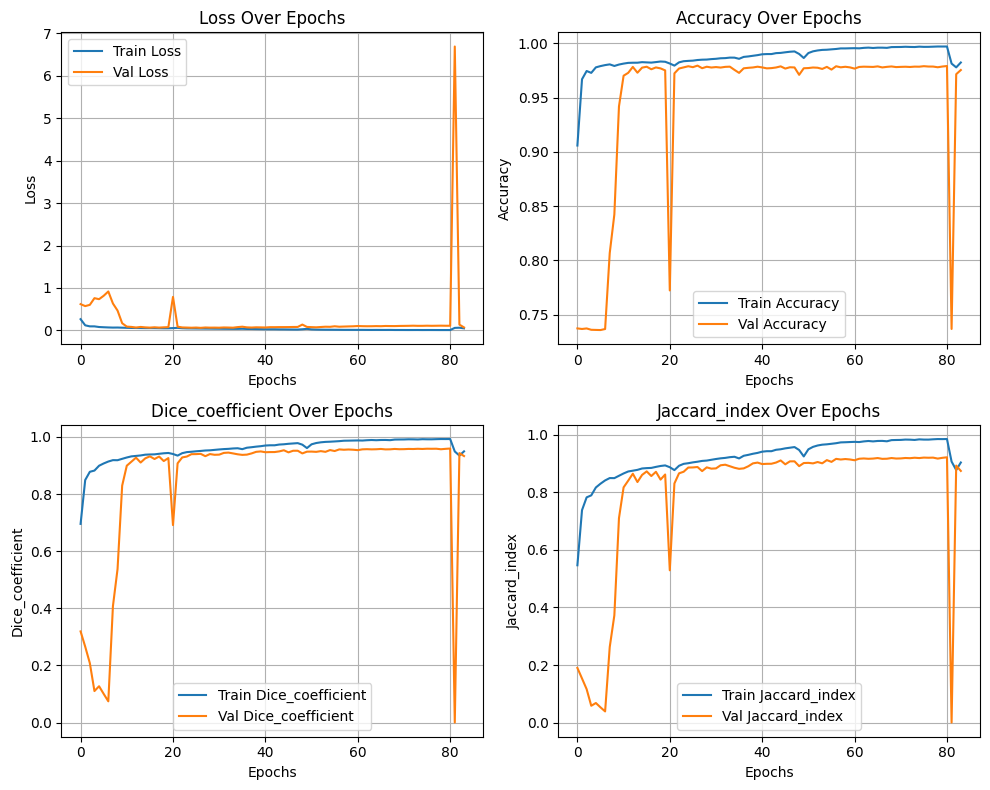

In [24]:
plot_training_history(seg_history,['loss', 'accuracy','dice_coefficient','jaccard_index'])

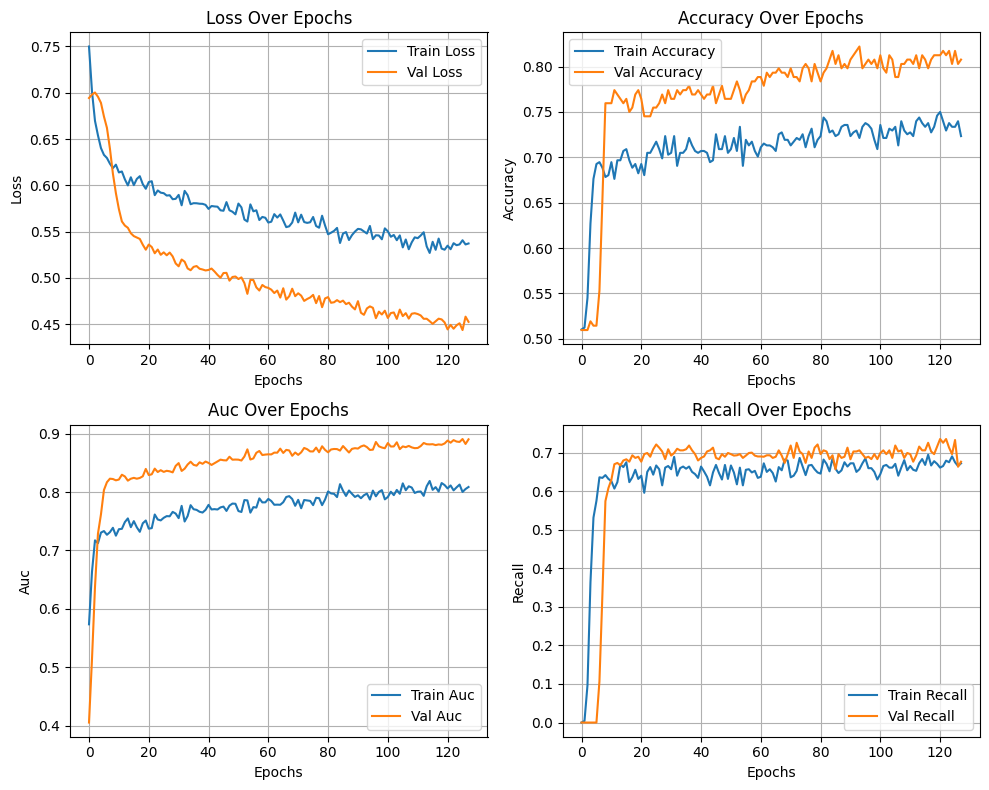

In [25]:
plot_training_history(clf_history,['loss', 'accuracy', 'auc', 'recall'])

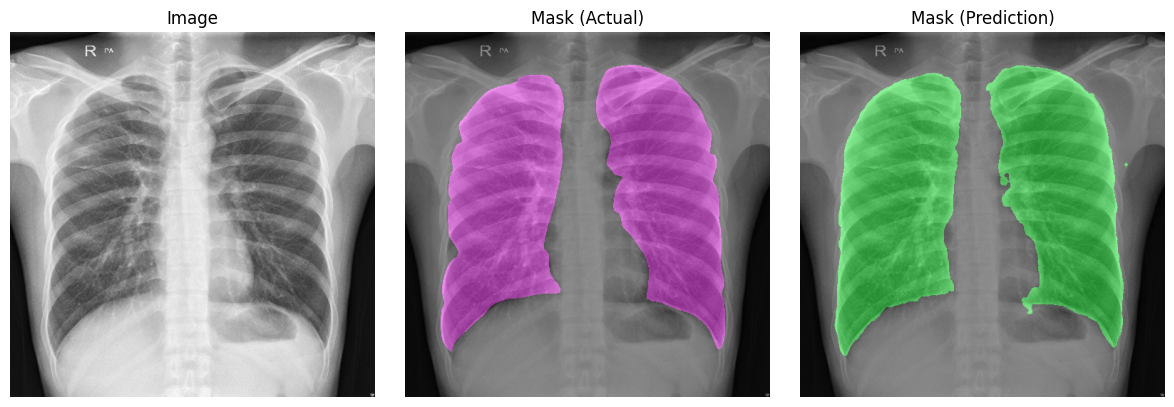

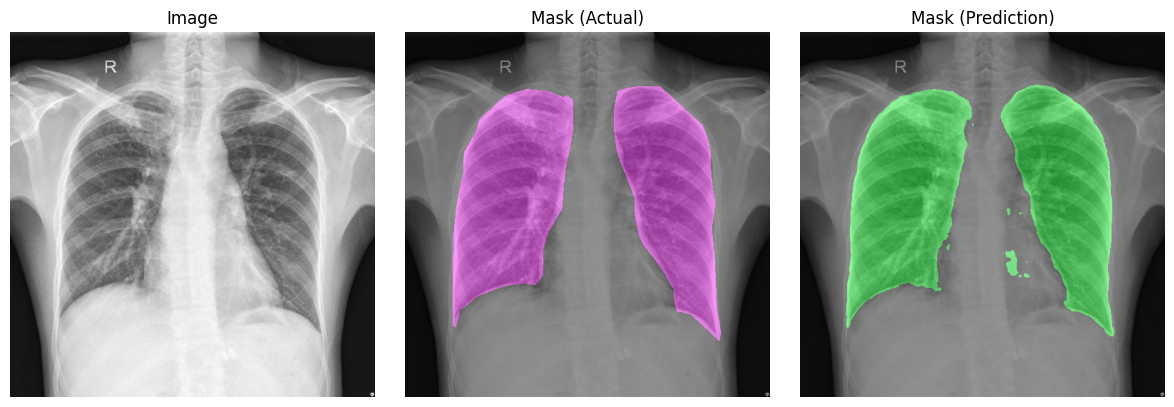

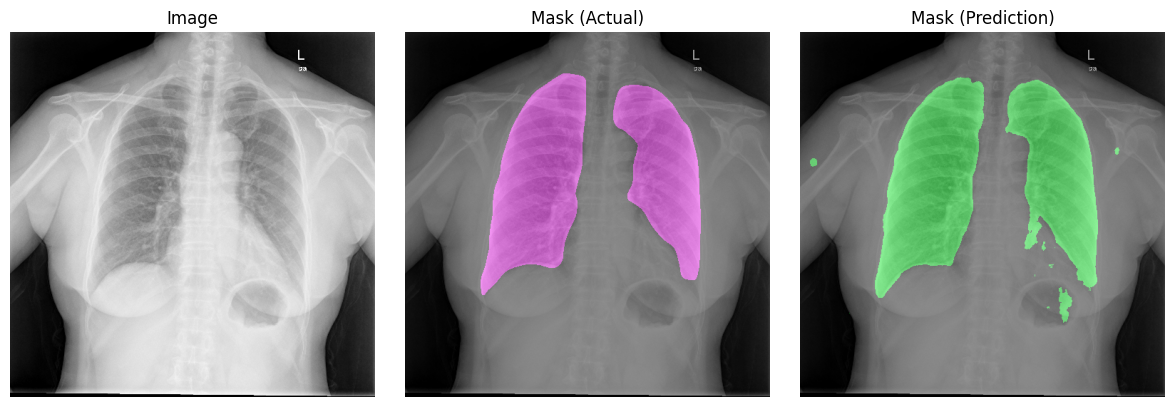

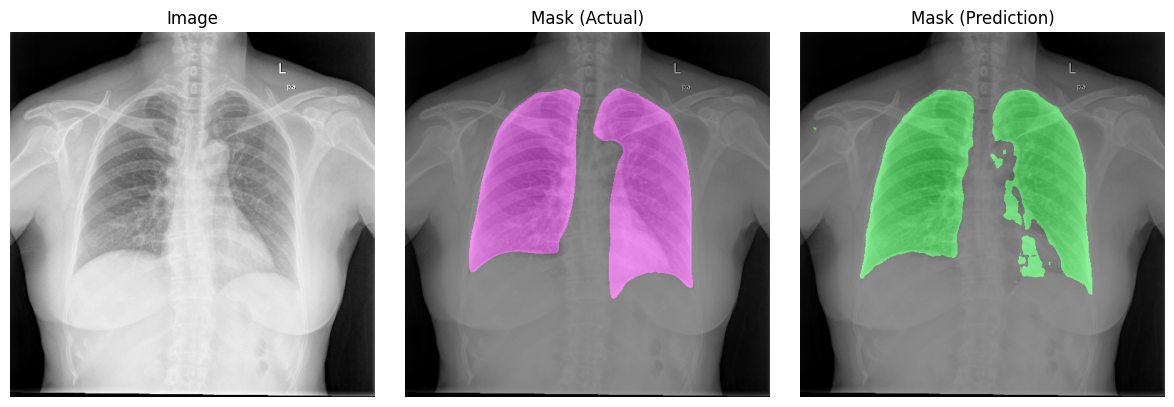

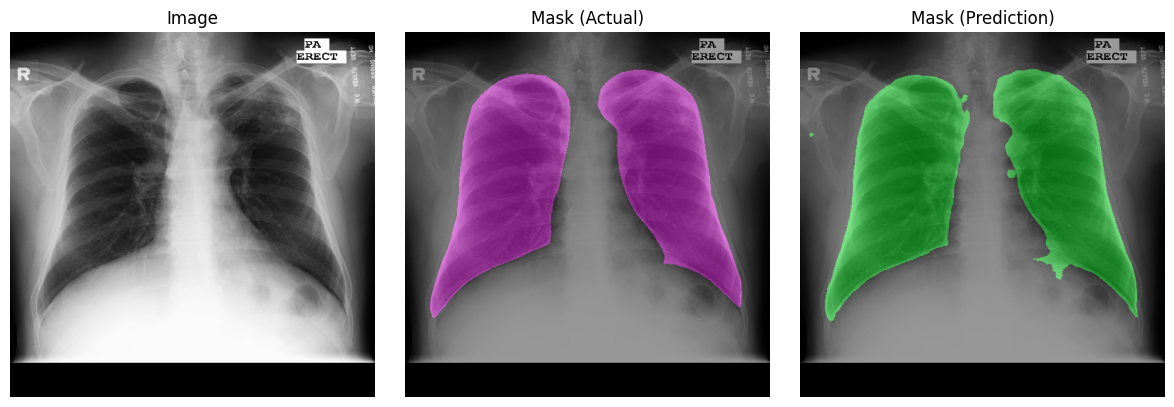

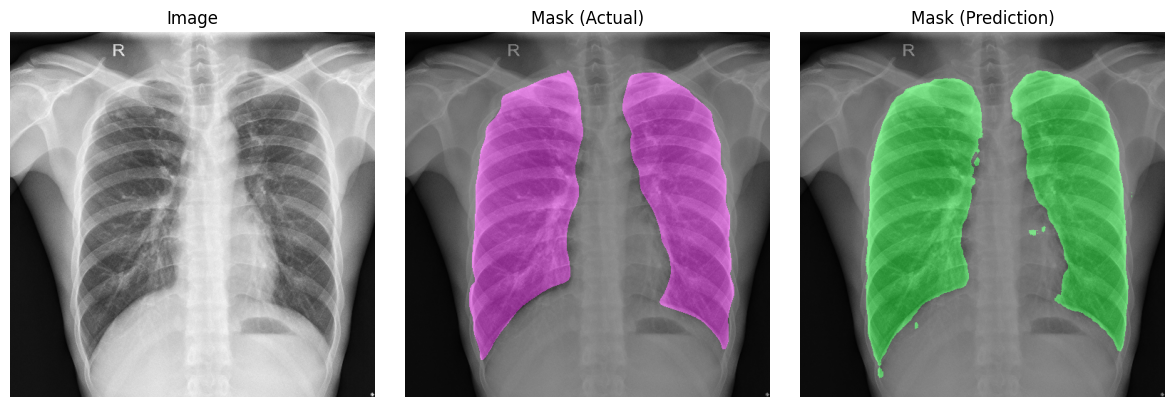

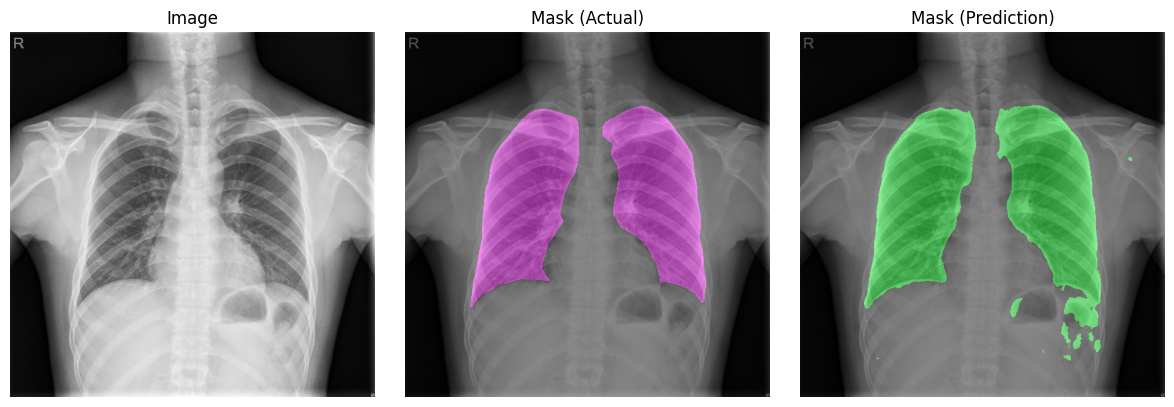

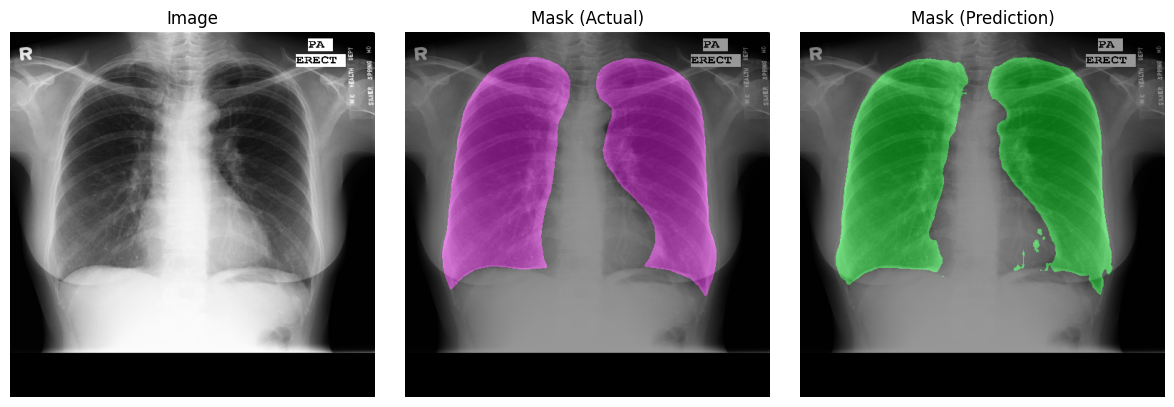

In [26]:
plot_seg_preds(seg_model, val_seg_data)